In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 6.0MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 239kB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 296kB 5.4MB/s 


In [2]:
!wget https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1 -O erm.zip

--2021-03-10 08:32:49--  https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qrdswgzv63o3opg/datasetCorregido.zip [following]
--2021-03-10 08:32:49--  https://www.dropbox.com/s/dl/qrdswgzv63o3opg/datasetCorregido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbc6636fcd3b7a1037f2b9c99e0.dl.dropboxusercontent.com/cd/0/get/BKbOdi4rrnMzgobXNemr3m2Rt6rV0esB5krW4xBQ6JBDCX-l0f4waKkUTZB5hJF53svf5rSWECTuT84-sROUrk3SoZD3YukBHtVIXkKxOZZPtLynmYyVl_WUamZsgLFiKcOgjUbMF3IfqR6v3afQZZ8l/file?dl=1# [following]
--2021-03-10 08:32:50--  https://ucbc6636fcd3b7a1037f2b9c99e0.dl.dropboxusercontent.com/cd/0/get/BKbOdi4rrnMzgobXNemr3m2Rt6rV0esB5krW4xBQ6JBDCX-l0f4waKkUTZB5h

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: datasetCorregido/
   creating: datasetCorregido/train/
   creating: datasetCorregido/train/no/
  inflating: datasetCorregido/train/no/anonymized_482127.jpg  
  inflating: datasetCorregido/train/no/anonymized_174749.jpg  
  inflating: datasetCorregido/train/no/anonymized_734047.jpg  
  inflating: datasetCorregido/train/no/anonymized_581767.jpg  
  inflating: datasetCorregido/train/no/anonymized_1400777.jpg  
  inflating: datasetCorregido/train/no/anonymized_347431.jpg  
  inflating: datasetCorregido/train/no/anonymized_626433.jpg  
  inflating: datasetCorregido/train/no/anonymized_1372303.jpg  
  inflating: datasetCorregido/train/no/anonymized_1324599.jpg  
  inflating: datasetCorregido/train/no/anonymized_196853.jpg  
  inflating: datasetCorregido/train/no/anonymized_687000.jpg  
  inflating: datasetCorregido/train/no/anonymized_504041.jpg  
  inflating: datasetCorregido/train/no/anonymized_1414333.jpg  
  inflating: datasetCorregido/train/no/anonymized_3

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('datasetCorregido/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,max_zoom=1.1,
                      max_lighting=0.1,p_lighting=0.5), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=32)

In [8]:
from fastai.vision.all import *
import timm
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18')
]

In [9]:
modelo=timm.models.hrnet.hrnet_w32(num_classes=2)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-hrnet/hrnetv2_w32-90d8c5fb.pth" to /root/.cache/torch/hub/checkpoints/hrnetv2_w32-90d8c5fb.pth


In [10]:
lr=1e-4

## Ranger

In [11]:
opt_func = partial(ranger, beta=0.99, eps=1e-6)

In [12]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=1.9054607152938843)

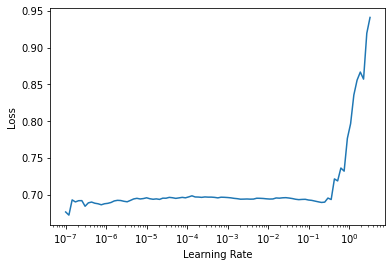

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.697779,0.685348,0.544343,0.555283,0.658892,03:22
1,0.697700,0.685040,0.529052,0.550143,0.559767,03:21


Better model found at epoch 0 with valid_loss value: 0.6853482723236084.


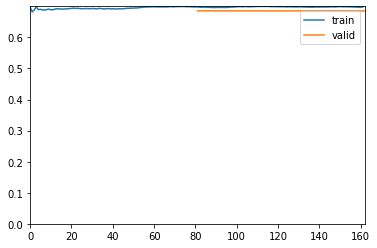

Better model found at epoch 1 with valid_loss value: 0.6850400567054749.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.694341,0.686049,0.544343,0.574257,0.507289,03:20
1,0.696012,0.685770,0.532110,0.554896,0.545190,03:21
2,0.696475,0.688030,0.529052,0.563636,0.451895,03:21
3,0.693528,0.687280,0.550459,0.594595,0.448980,03:21
4,0.694021,0.686485,0.551988,0.599206,0.440233,03:21


Better model found at epoch 0 with valid_loss value: 0.6860488057136536.


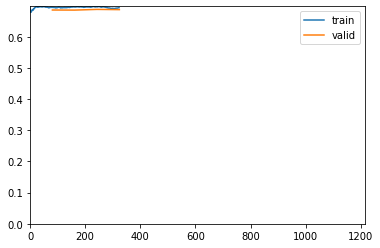

Better model found at epoch 1 with valid_loss value: 0.6857700347900391.
No improvement since epoch 1: early stopping


In [14]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [15]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

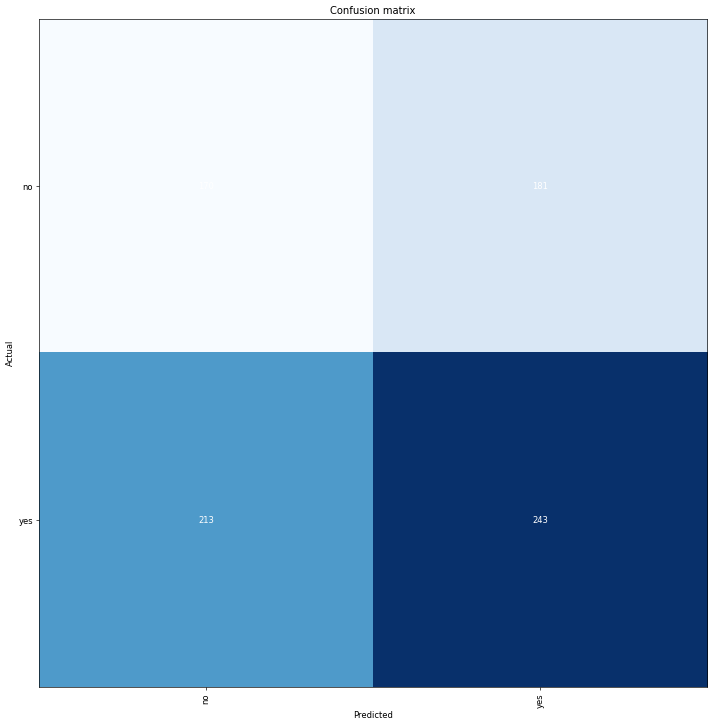

In [16]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [17]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5117719769477844.


(#4) [0.6915510296821594,0.5117719769477844,0.5731132075471698,0.5328947368421053]

## Faltten

In [18]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.723669,0.711910,0.475535,0.000000,0.000000,03:18
1,0.703439,0.692306,0.535168,0.554318,0.580175,03:18


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.7119100093841553.


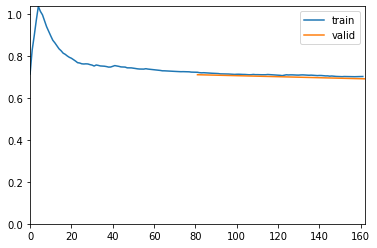

Better model found at epoch 1 with valid_loss value: 0.6923058032989502.


In [19]:
learn.fit_flat_cos(2,lr=1e-3)

In [20]:
learn.unfreeze()

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=1.9054607152938843)

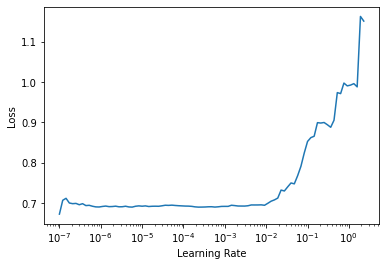

In [21]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.685050,0.679329,0.562691,0.580282,0.600583,03:18
1,0.660904,0.713039,0.559633,0.898551,0.180758,03:18
2,0.634137,0.632957,0.633027,0.761421,0.437318,03:18
3,0.604262,0.628141,0.637615,0.726496,0.495627,03:18
4,0.583112,0.679688,0.617737,0.788820,0.370262,03:18
5,0.567865,0.760505,0.571865,0.870588,0.215743,03:18
6,0.558848,0.563729,0.711009,0.734756,0.702624,03:18
7,0.545539,0.583760,0.698777,0.774436,0.600583,03:18
8,0.530068,0.570968,0.714067,0.782609,0.629738,03:18
9,0.505932,0.563120,0.727829,0.775920,0.676385,03:18


Better model found at epoch 0 with valid_loss value: 0.6793287396430969.


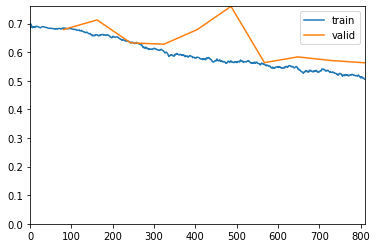

Better model found at epoch 2 with valid_loss value: 0.6329566836357117.
Better model found at epoch 3 with valid_loss value: 0.6281405091285706.
Better model found at epoch 6 with valid_loss value: 0.563729465007782.
Better model found at epoch 9 with valid_loss value: 0.5631195306777954.


In [22]:
learn.fit_flat_cos(10,lr=1e-4)

In [23]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

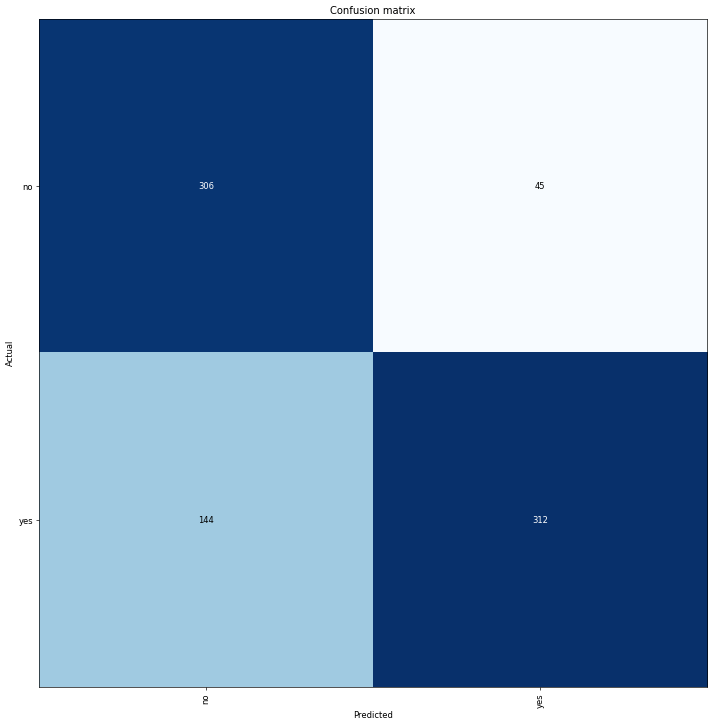

In [24]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [25]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7657992839813232.


(#4) [0.5025635361671448,0.7657992839813232,0.8739495798319328,0.6842105263157895]

## LabelSmoothing

In [26]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=5.754399353463668e-06)

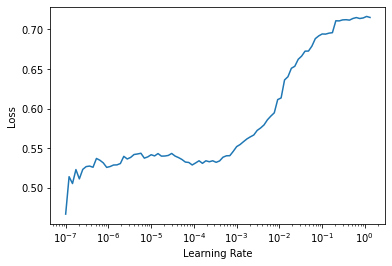

In [27]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.526445,0.585264,0.724771,0.736232,0.740525,03:18
1,0.534274,0.590679,0.733945,0.760000,0.720117,03:18


Better model found at epoch 0 with valid_loss value: 0.5852637887001038.


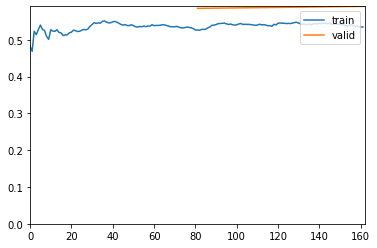

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.528030,0.587766,0.726300,0.756250,0.705539,03:18
1,0.526878,0.584262,0.726300,0.729050,0.760933,03:18
2,0.531346,0.588839,0.735474,0.801418,0.658892,03:18
3,0.533175,0.582566,0.707951,0.718391,0.728863,03:18
4,0.541280,0.573854,0.732416,0.802158,0.650146,03:18
5,0.524322,0.601124,0.712538,0.781818,0.626822,03:18
6,0.517570,0.606567,0.711009,0.776978,0.629738,03:18
7,0.514866,0.574476,0.735474,0.744253,0.755102,03:18


Better model found at epoch 0 with valid_loss value: 0.5877657532691956.


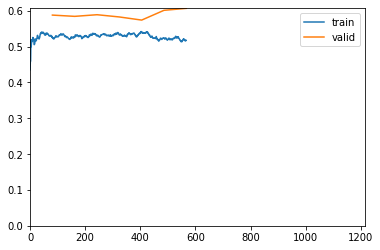

Better model found at epoch 1 with valid_loss value: 0.5842621326446533.
Better model found at epoch 3 with valid_loss value: 0.5825664401054382.
Better model found at epoch 4 with valid_loss value: 0.573853611946106.
No improvement since epoch 4: early stopping


In [28]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [29]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

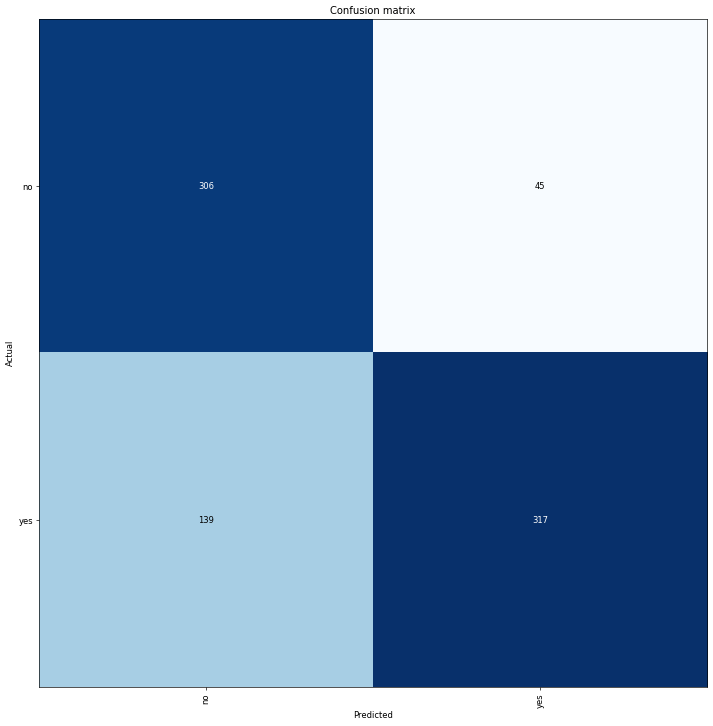

In [30]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [31]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7719950675964355.


(#4) [0.5445335507392883,0.7719950675964355,0.8756906077348067,0.6951754385964912]

## MixUp

In [32]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [33]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.553249,0.530157,0.735474,0.750000,0.743440,03:18
1,0.555948,0.559710,0.730887,0.765079,0.702624,03:18


Better model found at epoch 0 with valid_loss value: 0.5301568508148193.


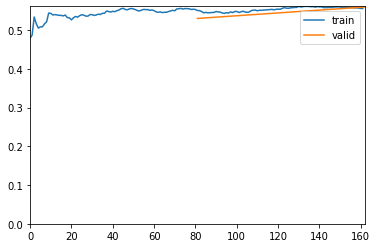

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.548962,0.534428,0.727829,0.775920,0.676385,03:18
1,0.542119,0.548904,0.726300,0.788732,0.653061,03:18
2,0.547118,0.533060,0.735474,0.750000,0.743440,03:18
3,0.538617,0.562303,0.727829,0.775920,0.676385,03:18
4,0.550593,0.535103,0.733945,0.760000,0.720117,03:18
5,0.544317,0.552104,0.717125,0.733728,0.723032,03:18


Better model found at epoch 0 with valid_loss value: 0.5344276428222656.


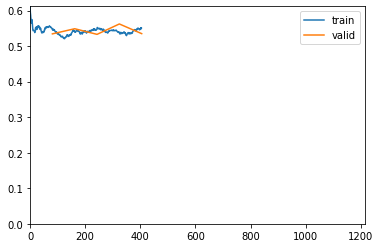

Better model found at epoch 2 with valid_loss value: 0.5330601334571838.
No improvement since epoch 2: early stopping


In [34]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [35]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

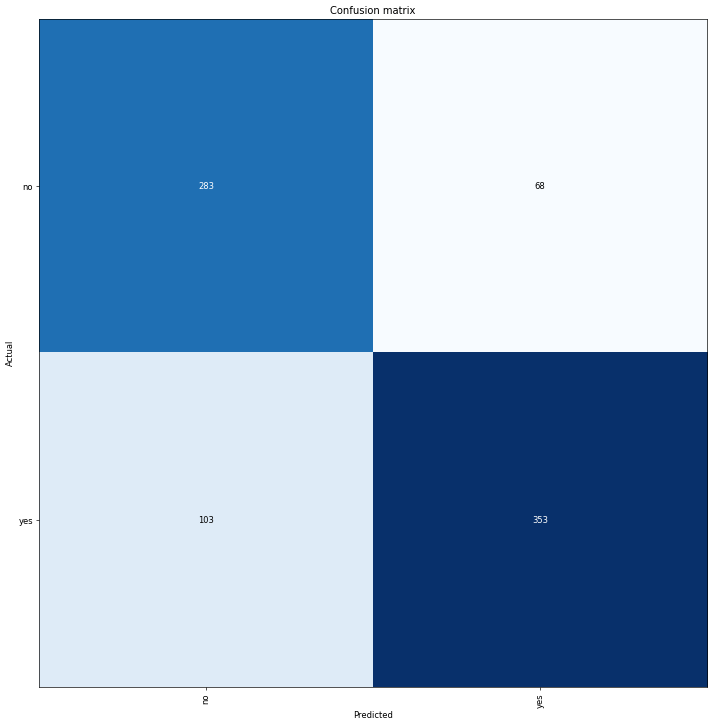

In [36]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [37]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7881041169166565.


(#4) [0.45894601941108704,0.7881041169166565,0.838479809976247,0.7741228070175439]

## Ranger + Flat cosin Anneal

In [38]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.464430,0.532388,0.733945,0.764890,0.711370,03:20
1,0.457597,0.533084,0.733945,0.766562,0.708455,03:21


Better model found at epoch 0 with valid_loss value: 0.5323881506919861.


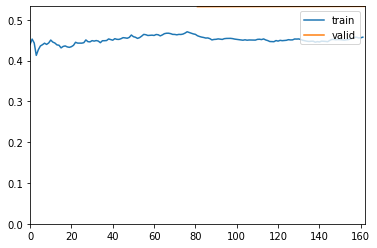

In [39]:
learn.fit_flat_cos(2,lr=1e-3)

In [40]:
learn.unfreeze()

SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=1.9054607491852948e-06)

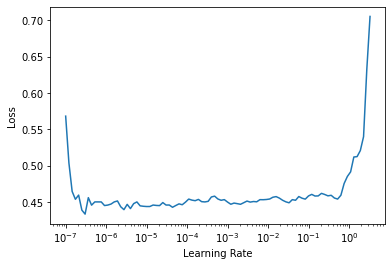

In [41]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.457057,0.531622,0.735474,0.762346,0.720117,03:20
1,0.457293,0.534125,0.743119,0.783172,0.705539,03:21
2,0.455011,0.534702,0.740061,0.778135,0.705539,03:21
3,0.453211,0.533707,0.735474,0.770701,0.705539,03:21


Better model found at epoch 0 with valid_loss value: 0.531621515750885.


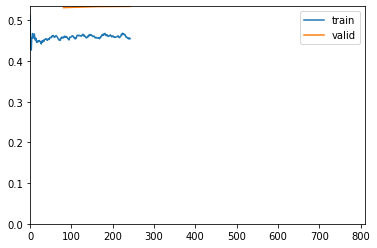

No improvement since epoch 0: early stopping


In [42]:
learn.fit_flat_cos(10,lr=1e-4)

In [43]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [44]:
learn.dls = dlsTest

In [45]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7843866348266602.


(#4) [0.4659116864204407,0.7843866348266602,0.8472906403940886,0.7543859649122807]

## Ranger+Flar Cossin Anneal+LabelSmoothing

In [46]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.502958,0.571508,0.735474,0.770701,0.705539,03:20
1,0.497182,0.570565,0.741590,0.782468,0.702624,03:21


Better model found at epoch 0 with valid_loss value: 0.5715081691741943.


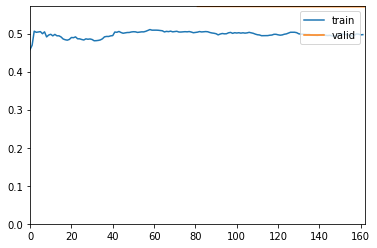

Better model found at epoch 1 with valid_loss value: 0.5705645680427551.


In [47]:
learn.fit_flat_cos(2,lr=1e-3)

In [48]:
learn.unfreeze()

SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=7.585775847473997e-07)

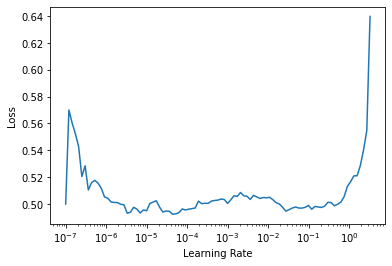

In [49]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.509785,0.569319,0.733945,0.764890,0.711370,03:20
1,0.502141,0.573102,0.738532,0.779221,0.699708,03:21
2,0.503088,0.572611,0.741590,0.782468,0.702624,03:21
3,0.503489,0.568867,0.733945,0.760000,0.720117,03:21
4,0.502937,0.571237,0.737003,0.763077,0.723032,03:21
5,0.501623,0.573116,0.737003,0.778502,0.696793,03:21
6,0.504539,0.572732,0.738532,0.775641,0.705539,03:21


Better model found at epoch 0 with valid_loss value: 0.5693190097808838.


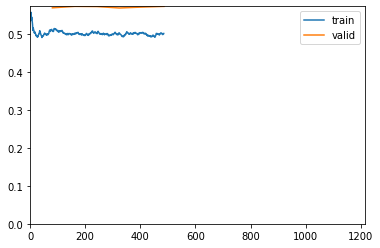

Better model found at epoch 3 with valid_loss value: 0.5688673257827759.
No improvement since epoch 3: early stopping


In [50]:
learn.fit_flat_cos(15,lr=1e-4)

In [51]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [52]:
learn.dls = dlsTest

In [53]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7781908512115479.


(#4) [0.5103657841682434,0.7781908512115479,0.8402948402948403,0.75]

## Ranger +Flat + Label + MixUp

In [54]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.562614,0.575344,0.740061,0.764526,0.728863,03:20


Better model found at epoch 0 with valid_loss value: 0.575344443321228.


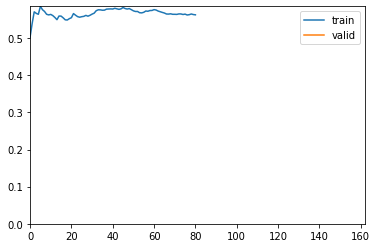

In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_flat_cos(15,lr=1e-4)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

## Ranger + Flat + MixUp

In [ ]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_flat_cos(15,lr=1e-4)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

## Ranger + MixUp

In [ ]:
#opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

In [ ]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

## Faltten + MixUp

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_flat_cos(10,lr=1e-4)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

## Ranger + Label

In [ ]:
#opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

In [ ]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

## Faltten + Label

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(10,lr=1e-4)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

## Label + MixUp

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

In [ ]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()